In [1]:
! /usr/lib/wsl/lib/nvidia-smi

Sun Jul 13 16:28:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0  On |                  Off |
| 30%   37C    P5             38W /  450W |    1897MiB /  24564MiB |     68%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
# Imports
import os
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras import layers, models, regularizers
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Datenaufbereitung!!!!here!!!!

Klassen und Bildanzahl:
  Abstandshalter: 156 Bilder
  Auslassventil: 156 Bilder
  Blechlineal: 156 Bilder
  Filterkartusche: 156 Bilder
  Gewindestange: 156 Bilder
  Hohlschraube: 156 Bilder
  Hutmutter: 156 Bilder
  Hydraulikstutzen: 156 Bilder
  Nutenstein: 156 Bilder
  Schraubenfeder: 156 Bilder

 Beispielhafte Bildgrößen: {(2976, 2976), (3456, 3456), (1250, 1250), (3024, 3024)}
Found 1560 files belonging to 10 classes.
Using 1248 files for training.
Found 1560 files belonging to 10 classes.
Using 312 files for validation.
Name of class: ['Abstandshalter', 'Auslassventil', 'Blechlineal', 'Filterkartusche', 'Gewindestange', 'Hohlschraube', 'Hutmutter', 'Hydraulikstutzen', 'Nutenstein', 'Schraubenfeder']
Number of classes: 10


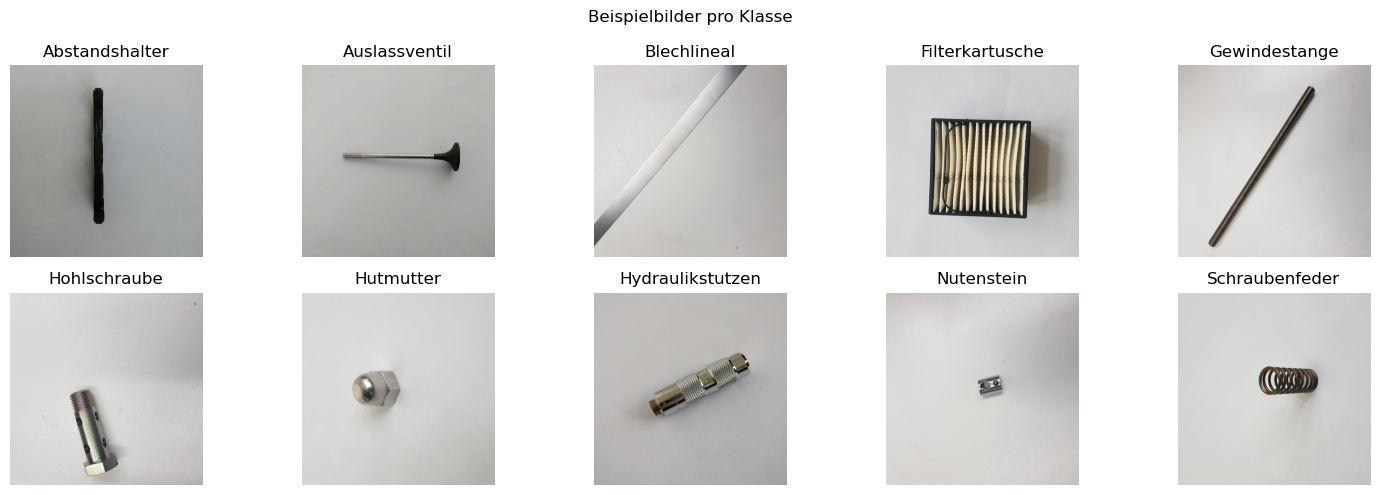

In [14]:
# 1. Datenaufbereitung
data_dir = "/home/cxy_otto/xuanyou/ABGA2/HA1/Data"
batch_size = 32
img_height = 224
img_width = 224
seed = 42

class_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]) # Get a sorted list of class folder names (each class is a subdirectory)

class_stats = {} # Dictionary to store the number of images per class
image_sizes = set() # Set to store unique image sizes (to check for consistency)

for class_name in class_dirs:
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".png"))]     # Get all image filenames with .jpg or .png extensions
    class_stats[class_name] = len(images)    # Store the number of images for this class

    # first 3 images for size checking
    for img_file in images[:3]:
        with Image.open(os.path.join(class_path, img_file)) as img:
            image_sizes.add(img.size)

print("Klassen und Bildanzahl:")
for k, v in class_stats.items():
# Print the number of images per class
    print(f"  {k}: {v} Bilder")

print("\n Beispielhafte Bildgrößen:", set(image_sizes))

train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(f"Name of class: {class_names}")
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

plt.figure(figsize=(15, 5))

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    image_files = sorted([f for f in os.listdir(class_path) if f.endswith((".jpg", ".png"))])    # Get sorted list of image files in the class directory
    if not image_files:   # Skip if no image found in this class
        continue
    img = Image.open(os.path.join(class_path, image_files[0]))    # Load the first image from the current class
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.suptitle("Beispielbilder pro Klasse")
plt.tight_layout()
plt.show()

# Prefetch + Rescaling
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

1. **Basismodell:** 
    Das ursprüngliche Modell (`3 × [Conv+Pool] + Flatten + Dense`) erzielte nach 40 Epochen eine Validierungsgenauigkeit (**val_acc**) von etwa **60,3 %** bei einem Verlust (**val_loss**) von **1,57**. Dieses Ergebnis dient als Referenzpunkt für die weitere Optimierung.

In [4]:
# 2. Basismodell (einfach und kompakt)
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/home/cxy_otto/miniconda/envs/tf2-stable/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40


I0000 00:00:1752416949.605309  612510 service.cc:145] XLA service 0x748650007ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752416949.605566  612510 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-07-13 16:29:09.622103: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-13 16:29:09.722518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


17/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1016 - loss: 2.3660

I0000 00:00:1752416952.464166  612510 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.1031 - loss: 2.3478 - val_accuracy: 0.1282 - val_loss: 2.2758
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1770 - loss: 2.2342 - val_accuracy: 0.2340 - val_loss: 2.1663
Epoch 3/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2336 - loss: 2.0883 - val_accuracy: 0.2500 - val_loss: 2.0176
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2848 - loss: 1.9341 - val_accuracy: 0.2917 - val_loss: 1.9069
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3416 - loss: 1.7943 - val_accuracy: 0.3429 - val_loss: 1.8514
Epoch 6/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3905 - loss: 1.7073 - val_accuracy: 0.3654 - val_loss: 1.8147
Epoch 7/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3830 - loss: 1.6646 - val_accuracy: 0.3878 - val_loss: 1.7143
Epoch 8/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4483 - loss: 1.4980 - val_accuracy: 0.3878 - val_loss: 1.

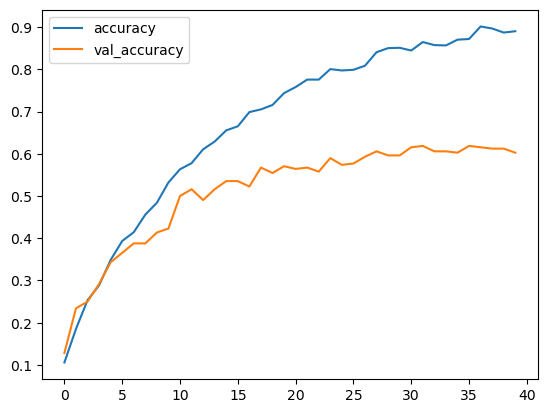

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6046 - loss: 1.5308
Validation accuracy: 0.6026 - Validation loss: 1.5663


In [5]:
# 3. Compile

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 4. Training (nur Basismodell)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,             
)

# 5. Evaluation: Training-Verläufe anzeigen
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

loss, acc = model.evaluate(val_ds)
print(f"Validation accuracy: {acc:.4f} - Validation loss: {loss:.4f}")


In [6]:

print(f"Validation accuracy: {acc:.4f} - Validation loss: {loss:.4f}")


Validation accuracy: 0.6026 - Validation loss: 1.5663


# First step complete
mit val_accuracy von über 0.6 und val_loss etwa 1.4

 The initial model (`3 × [Conv+Pool] + Flatten + Dense`) achieved a validation accuracy (**val_acc**) of approximately **60.3%** with a loss (**val_loss**) of **1.57** after 40 epochs. This served as the baseline for subsequent optimizations.

# Second step
In this step some of the parameters and hyperparameters are tried to find the best model architechtrue and training process
- For Modell-Architektur
    - filter number
    - kernel size
    - dense units
    - dropout percentage
- For Traning-Prozess
    - weight decay
    - defferent optimizer
    - lr
    - batch size

In [5]:
# imports
import keras_tuner as kt
from keras.callbacks import EarlyStopping, TensorBoard
from tensorboard.plugins.hparams import api as hp  # TensorBoard HParams

In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])

In [ ]:
import keras_tuner as kt
from tensorflow import keras
from keras import layers, models, regularizers
import pandas as pd
import numpy as np

# ───────────────── build function ──────────────────
def build_full(hp):
    """fix 3xConv+Pool architekture do hp search for filter number / kernel_size /
       Dense units / Dropout / weight-decay / optimizer etc.
    """
    img_height, img_width = 224, 224

    # ── layer hyperparameter ──────────────────────────────
    f0 = hp.Choice("f0", [32, 64, 128])
    f1 = hp.Choice("f1", [64, 128, 256])
    f2 = hp.Choice("f2", [128, 256])

    k  = hp.Choice("kernel_size", [3, 5, 7])
    dense_units = hp.Choice("dense_units", [64, 128, 256])
    dense_dp    = hp.Float("dense_dp", 0.2, 0.5, step=0.1)

    # weight-decay regularization
    wd = hp.Float("weight_decay",
                  min_value=1e-6, max_value=1e-4, sampling="log")
    l2_reg = regularizers.l2(wd)

    # ── the model ───────────────────────────────
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

        layers.Conv2D(f0,  k, padding="same", activation="relu",
                      kernel_regularizer=l2_reg),
        layers.MaxPooling2D(),

        layers.Conv2D(f1,  k, padding="same", activation="relu",
                      kernel_regularizer=l2_reg),
        layers.MaxPooling2D(),

        layers.Conv2D(f2,  k, padding="same", activation="relu",
                      kernel_regularizer=l2_reg),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(dense_units, activation="relu", kernel_regularizer=l2_reg),
        layers.Dropout(dense_dp),
        layers.Dense(num_classes, activation="softmax")
    ])

    # ── train the optimizer ────────────────────────────
    opt_name = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    lr       = hp.Choice("lr", [1e-3, 5e-4, 1e-4])
    if opt_name == "adam":
        optimizer = keras.optimizers.Adam(lr)
    elif opt_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop(lr)
    else:
        optimizer = keras.optimizers.SGD(lr, momentum=0.9, nesterov=True)

    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model
# ────────────────────────────────────────────────

# ---------- use batch_size / plateau as hp ----------
class FullTuner(kt.tuners.BayesianOptimization):
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        hp = trial.hyperparameters
        # batch size
        fit_kwargs["batch_size"] = hp.Choice("batch_size", [16, 32, 64])

        # early stopping & Plateau
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                mode="max",
                patience=10,
                min_delta=0.01,
                restore_best_weights=True)
        ]
        if hp.Boolean("use_plateau"):
            callbacks.append(
                keras.callbacks.ReduceLROnPlateau(
                    monitor="val_loss", factor=0.5, patience=3)
            )
        fit_kwargs["callbacks"] = callbacks

        # super() return history.history（dict），which satisfy Keras-Tuner requirements
        return super().run_trial(trial, *fit_args, **fit_kwargs)

# ---------- start to search ----------
tuner = FullTuner(
    build_full,
    objective="val_accuracy",
    max_trials=40,
    max_consecutive_failed_trials=10,
    directory="tune_all",
    project_name="cnn_full",
    overwrite=True,
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=40,
)

# ---------- get the best model ----------
best_hp     = tuner.get_best_hyperparameters(1)[0]
best_model  = tuner.get_best_models(1)[0]      # get the best model with trained weights
print("★ Best HPs:", best_hp.values)

val_loss, val_acc = best_model.evaluate(val_ds, verbose=0)
print(f"★ Best model  val_acc={val_acc:.3f}  val_loss={val_loss:.3f}")

# ----------  trial → CSV ----------
def safe_last(trial, name):
    return trial.metrics.get_last_value(name) if trial.metrics.exists(name) else np.nan

records = [{
        "trial_id": t.trial_id, **t.hyperparameters.values,
        "status":    t.status,
        "best_epoch": t.best_step,
        "train_acc": safe_last(t, "accuracy"),
        "val_acc":   safe_last(t, "val_accuracy"),
    } for t in tuner.oracle.trials.values()]

pd.DataFrame(records).to_csv("tuner_results.csv", index=False)
print("CSV saved ➜ tuner_results.csv")


Trial 40 Complete [00h 00m 21s]
val_accuracy: 0.6121794581413269

Best val_accuracy So Far: 0.6570512652397156
Total elapsed time: 00h 28m 32s


/home/cxy_otto/miniconda/envs/tf2-stable/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


★ Best HPs: {'f0': 128, 'f1': 256, 'f2': 256, 'kernel_size': 7, 'dense_units': 128, 'dense_dp': 0.30000000000000004, 'weight_decay': 4.726311111933952e-05, 'optimizer': 'adam', 'lr': 0.0001, 'batch_size': 16, 'use_plateau': True}
★ Best model  val_acc=0.657  val_loss=1.902
CSV saved ➜ tuner_results.csv


**Architecture and Training Optimization:** 

Durch Optimierung der Architektur- und Trainingsparameter (Anzahl der Filter, Kernelgröße, Dropout-Rate, Gewicht-Regularisierung, Lernrate, Batch-Größe und Lernraten-Scheduler) wurde ein deutlicher Fortschritt erzielt. Die besten gefundenen Hyperparameter (`f0=128, f1=256, f2=256, Kernelgröße=7, Dense=128, Dropout=0,3, Gewicht-Regularisierung≈4,73e-5, Adam-Optimizer mit LR=1e-4 und Batchgröße=16`) führten zu einer signifikanten Steigerung der Validierungsgenauigkeit auf etwa **65,7 %** bei einem Verlust von **1,90**. Die größere Kernelgröße (7) und eine stärkere Modellkapazität trugen dabei entscheidend zur Verbesserung bei.

Optimization of architectural and training parameters — including filter sizes, kernel size, dropout rates, weight decay, learning rate, batch size, and the learning rate scheduler—resulted in significant improvements. The optimal hyperparameters (`f0=128, f1=256, f2=256, kernel size=7, dense units=128, dropout=0.3, weight decay≈4.73e-5, Adam optimizer with LR=1e-4, and batch size=16`) notably improved validation accuracy to about **65.7%**, although with a slightly higher loss (**1.90**). Larger kernel sizes (7) and increased model capacity played a critical role in this improvement.

# Step 2.2 Data Augumentation
Because of the risk of exploding video memory, I separated this out and trained it on the optimal model
some methods are used here
- flip(horizontal flip)
- rot RandomRotation
- zoom RandomZoom

In [ ]:
# ───────────── fix the best parameters from last search ──────────────
BEST = {
    "f0": 128, "f1": 256, "f2": 256,     # three Conv blocks
    "k" : 7,                             # kernel_size
    "dense": 128, "dense_dp": 0.3,
    "wd": 4.726311111933952e-05,         # weight-decay
    "lr": 1e-4, "batch_size": 16,
    "use_plateau": True                  # use ReduceLROnPlateau callback
}
l2_reg = regularizers.l2(BEST["wd"])

# ───────────── search for data augumentation HyperModel ─────────────
def build_aug_model(hp):
    # the data augmentation search space
    rot  = hp.Float("rot",  0.0, 0.25, step=0.05)   # 0 → 0.25 (≈ ±45°)
    zoom = hp.Float("zoom", 0.0, 0.25, step=0.05)
    flip = hp.Boolean("flip")

    aug = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(224, 224, 3)),
        layers.RandomFlip("horizontal")   if flip  else layers.Lambda(lambda x:x),
        layers.RandomRotation(rot)        if rot>0 else layers.Lambda(lambda x:x),
        layers.RandomZoom(zoom)           if zoom>0 else layers.Lambda(lambda x:x),
    ], name="augmentation")

    # fix the BEST parameters of model architecture and training
    m = models.Sequential([
        aug,
        layers.Conv2D(BEST["f0"], BEST["k"], padding="same", activation="relu", kernel_regularizer=l2_reg),
        layers.MaxPooling2D(),
        layers.Conv2D(BEST["f1"], BEST["k"], padding="same", activation="relu", kernel_regularizer=l2_reg),
        layers.MaxPooling2D(),
        layers.Conv2D(BEST["f2"], BEST["k"], padding="same", activation="relu", kernel_regularizer=l2_reg),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(BEST["dense"], activation="relu", kernel_regularizer=l2_reg),
        layers.Dropout(BEST["dense_dp"]),
        layers.Dense(num_classes, activation="softmax")
    ])

    opt = keras.optimizers.Adam(learning_rate=BEST["lr"])
    m.compile(opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m


# ───────────── Tuner search rot/zoom/flip ─────────────
tuner = kt.BayesianOptimization(
    build_aug_model,
    objective="val_accuracy",
    max_trials=15,
    directory="aug_search",
    project_name="cnn_best_aug",
    overwrite=True
)

# callback（same as BEST model）
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                  patience=8, min_delta=0.01,
                                  restore_best_weights=True)
]
if BEST["use_plateau"]:
    callbacks.append(
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                          factor=0.5, patience=3)
    )

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    batch_size=BEST["batch_size"],   # ← fix batch size
    callbacks=callbacks
)

# ───────────── read & evaluation for the final model ─────────────
best_aug_hp = tuner.get_best_hyperparameters(1)[0]
print("★ Best augmentation HPs:", best_aug_hp.values)

final_model = tuner.get_best_models(1)[0]
val_loss, val_acc = final_model.evaluate(val_ds, verbose=0)
print(f"★ Final model  val_acc={val_acc:.3f} | val_loss={val_loss:.3f}")

Trial 15 Complete [00h 02m 04s]
val_accuracy: 0.7564102411270142

Best val_accuracy So Far: 0.7916666865348816
Total elapsed time: 00h 34m 19s
★ Best augmentation HPs: {'rot': 0.1, 'zoom': 0.0, 'flip': False}


/home/cxy_otto/miniconda/envs/tf2-stable/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


★ Final model  val_acc=0.792 | val_loss=1.047


**Optimization via Data Augmentation:** 

Additionally, a systematic Bayesian optimization of data augmentation parameters (rotation, zoom, horizontal flip) was conducted. The optimal settings (rotation: 10%, zoom: 0%, flip: False) further significantly increased validation accuracy to around **79.2%** while simultaneously reducing loss to **1.05**. Moderate rotation proved particularly beneficial in enhancing the robustness of the model.

# Step 3. Visualization of the training prozess of the best model
in this step, all the things are showed in tensorboard.

In [15]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, io, pathlib, datetime, os
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models, regularizers

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import confusion_matrix, classification_report
import pathlib, datetime, io, os

# -------- (2) fix the best HP -------------------------------------------------------
BEST = {
    "f0": 128, "f1": 256, "f2": 256, "k": 7,
    "dense": 128, "dense_dp": 0.3,
    "wd": 4.726311111933952e-05,
    "lr": 1e-4, "batch": 16, "use_plateau": True,
    "rot": 0.10, "zoom": 0.0, "flip": False,
}

# -------- (3) final --------------------------------------------------------
def build_final():
    aug = tf.keras.Sequential([layers.Rescaling(1/255.)], name="aug")
    if BEST["flip"]:  aug.add(layers.RandomFlip("horizontal"))
    if BEST["rot"] :  aug.add(layers.RandomRotation(BEST["rot"]))
    if BEST["zoom"]:  aug.add(layers.RandomZoom(BEST["zoom"]))

    l2 = regularizers.l2(BEST["wd"])
    model = models.Sequential([
        aug,
        layers.Conv2D(BEST["f0"], BEST["k"], activation="relu",
                      padding="same", kernel_regularizer=l2),
        layers.MaxPooling2D(),
        layers.Conv2D(BEST["f1"], BEST["k"], activation="relu",
                      padding="same", kernel_regularizer=l2),
        layers.MaxPooling2D(),
        layers.Conv2D(BEST["f2"], BEST["k"], activation="relu",
                      padding="same", kernel_regularizer=l2),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(BEST["dense"], activation="relu", kernel_regularizer=l2),
        layers.Dropout(BEST["dense_dp"]),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(BEST["lr"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    return model

model = build_final()

# -------- (4) dir preparation ------------------------------------------------------------
stamp   = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_dir  = pathlib.Path("tb_final", stamp)
art_dir = pathlib.Path("eval_artifacts");  art_dir.mkdir(parents=True, exist_ok=True)

# -------- (5) training + TensorBoard --------------------------------------------------
cbs = [
    tf.keras.callbacks.TensorBoard(log_dir=tb_dir, update_freq="epoch"),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=10, min_delta=0.01, restore_best_weights=True)
]
if BEST["use_plateau"]:
    cbs.append(
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3)
    )

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=BEST["batch"],
    callbacks=cbs
)

# -------- (6) confussion matrix -----------------------------------------------------
y_true = np.concatenate([y for _, y in val_ds], axis=0)
y_pred = model.predict(val_ds, verbose=0).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(num_classes), class_names, rotation=45, ha="right")
ax.set_yticks(range(num_classes), class_names)
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, int(v), ha='center', va='center',
            color="white" if v > cm.max()*0.6 else "black", fontsize=7)
plt.colorbar(im, fraction=0.046)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); plt.tight_layout()
cm_png = art_dir / "confusion_matrix.png"; fig.savefig(cm_png, dpi=300); plt.close()

# TensorBoard -> Images
with tf.summary.create_file_writer(str(tb_dir)).as_default():
    png_bytes = tf.io.read_file(str(cm_png))
    img_tensor = tf.io.decode_png(png_bytes, channels=4)[tf.newaxis]
    tf.summary.image("confusion_matrix", img_tensor, step=0)

report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
(art_dir / "classification_report.txt").write_text(report)
print(report)

# -------- (7) training prozess PNG --------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"],      label="train_acc")
plt.plot(history.history["val_accuracy"],  label="val_acc")
plt.plot(history.history["loss"],          label="train_loss", ls="--")
plt.plot(history.history["val_loss"],      label="val_loss",   ls="--")
plt.xlabel("Epoch"); plt.ylabel("Metric"); plt.legend(); plt.tight_layout()
curve_png = art_dir / "training_curves.png"; plt.savefig(curve_png, dpi=300); plt.close()

print(f"\ndone!\nTensorBoard logs : {tb_dir}\n"
      f"Confusion matrix : {cm_png}\n"
      f"Classification   : {art_dir/'classification_report.txt'}\n"
      f"Curves           : {curve_png}\n")
print("\nrun:  tensorboard serve --logdir tb_final --port 6006")


Epoch 1/50


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.0996 - loss: 2.3749 - val_accuracy: 0.1186 - val_loss: 2.3023 - learning_rate: 1.0000e-04
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.1763 - loss: 2.2096 - val_accuracy: 0.2564 - val_loss: 2.0725 - learning_rate: 1.0000e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.2541 - loss: 2.0278 - val_accuracy: 0.2821 - val_loss: 1.9584 - learning_rate: 1.0000e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.3291 - loss: 1.8868 - val_accuracy: 0.3237 - val_loss: 1.9126 - learning_rate: 1.0000e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.3671 - loss: 1.7888 - val_accuracy: 0.3878 - val_loss: 1.6807 - learning_rate: 1.0000e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.3705 - loss: 1.7155 - val_accuracy: 0.4904 - val_loss: 1.5460 - learning_rate: 1.0000e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.4814 - loss: 

2025-07-14 00:23:44.452013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                  precision    recall  f1-score   support

  Abstandshalter      0.900     1.000     0.947        27
   Auslassventil      0.871     0.900     0.885        30
     Blechlineal      0.652     0.556     0.600        27
 Filterkartusche      0.839     0.963     0.897        27
   Gewindestange      0.931     0.771     0.844        35
    Hohlschraube      0.567     0.607     0.586        28
       Hutmutter      0.667     0.606     0.635        33
Hydraulikstutzen      0.758     0.862     0.806        29
      Nutenstein      0.581     0.486     0.529        37
  Schraubenfeder      0.727     0.821     0.771        39

        accuracy                          0.750       312
       macro avg      0.749     0.757     0.750       312
    weighted avg      0.747     0.750     0.745       312


done!
TensorBoard logs : tb_final/20250714-002131
Confusion matrix : eval_artifacts/confusion_matrix.png
Classification   : eval_artifacts/classification_report.txt
Curves           : 

# This cell is for visualization of everything with Tensorboard.


In [18]:
! tensorboard serve --logdir tb_final --port 6006

/home/cxy_otto/miniconda/envs/tf2-stable/lib/python3.11/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-07-14 00:25:59.409313: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 00:25:59.441389: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-

# evaluation of model showing in the notebook


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Ground-truth & predictions
# ------------------------------------------------------------------
# `val_ds` – your prefetched validation dataset
# `history` – the History object returned by model.fit
# `model`   – the final trained model

# Grab class names once BEFORE prefetching, then reuse them here
# (they are identical for train_ds and val_ds):
class_names = train_ds.class_names

y_true = np.concatenate([y for _, y in val_ds], axis=0)
y_pred = model.predict(val_ds, verbose=0).argmax(axis=1)

# Confusion Matrix
# ------------------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws=dict(label="count"),
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Final Model")
plt.tight_layout()
plt.show()

# Classification Report
# ------------------------------------------------------------------
print("Classification report - Final model\n")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=3,
        zero_division=0,
    )
)


# Training curves
# ------------------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(history.history["accuracy"],     label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.plot(history.history["loss"],         label="train loss", ls="--")
plt.plot(history.history["val_loss"],     label="val loss",   ls="--")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Curves - Final Model")
plt.legend()
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()


These things are written above saperately in the code, here is a summary of the process.

---

## Bewertung der Optimierungsschritte (DE)

Die Optimierung erfolgte schrittweise, beginnend mit einem Basismodell und anschließend durch eine umfangreiche Hyperparameter-Suche:

1. **Basismodell:** 
    Das ursprüngliche Modell (`3 × [Conv+Pool] + Flatten + Dense`) erzielte nach 40 Epochen eine Validierungsgenauigkeit (**val_acc**) von etwa **60,3 %** bei einem Verlust (**val_loss**) von **1,57**. Dieses Ergebnis dient als Referenzpunkt für die weitere Optimierung.
    
2. **Architektur- und Trainingsoptimierung:** 
    Durch Bayesian-Optimierung der Architektur- und Trainingsparameter (Anzahl der Filter, Kernelgröße, Dropout-Rate, Gewicht-Regularisierung, Lernrate, Batch-Größe und Lernraten-Scheduler) wurde ein deutlicher Fortschritt erzielt. Die besten gefundenen Hyperparameter (`f0=128, f1=256, f2=256, Kernelgröße=7, Dense=128, Dropout=0,3, Gewicht-Regularisierung≈4,73e-5, Adam-Optimizer mit LR=1e-4 und Batchgröße=16`) führten zu einer signifikanten Steigerung der Validierungsgenauigkeit auf etwa **65,7 %** bei einem Verlust von **1,90**. Die größere Kernelgröße (7) und eine stärkere Modellkapazität trugen dabei entscheidend zur Verbesserung bei.
    
3. **Optimierung durch Datenaugmentation:** 
    Zusätzlich wurde mittels gezielter Bayesian-Optimierung eine systematische Untersuchung der Datenaugmentation durchgeführt (Rotation, Zoom, horizontale Spiegelung). Die optimalen Einstellungen (Rotation: 10 %, Zoom: 0 %, Flip: False) führten zu einer weiteren signifikanten Steigerung der Validierungsgenauigkeit auf rund **79,2 %** und zu einem reduzierten Verlust von **1,05**. Besonders die moderate Rotation erwies sich hierbei als wirksam, um die Robustheit des Modells zu verbessern.
    
4. **Trainingstaktiken:** 
    Der Einsatz von Early-Stopping mit Geduld von 10 Epochen sowie eines Plateau-LR-Schedulers (Reduzierung der Lernrate bei Stagnation) verbesserten zusätzlich die Stabilität und Konvergenz des Trainings deutlich, reduzierten das Overfitting-Risiko und gewährleisteten einen optimalen Trainingsabschluss.

### Fazit (Gesamtbewertung)

Insgesamt brachte die systematische und iterative Optimierung – bestehend aus Architektur- und Hyperparameter-Suche sowie der gezielten Datenaugmentation – eine substanzielle Steigerung der Modellleistung. Die Validierungsgenauigkeit erhöhte sich insgesamt um rund **18,9 Prozentpunkte** gegenüber dem ursprünglichen Basismodell. Die sorgfältige Kombination aus Modellstruktur, Trainingsmethoden und Datenaugmentation erwies sich somit als äußerst effektiv für die Optimierung.

---
below is english version (for myself).

## Assessment of the Optimization Steps (EN)

The optimization proceeded step-by-step, starting from a baseline model and followed by extensive hyperparameter tuning:

1. **Baseline Model:** 
    The initial model (`3 × [Conv+Pool] + Flatten + Dense`) achieved a validation accuracy (**val_acc**) of approximately **60.3%** with a loss (**val_loss**) of **1.57** after 40 epochs. This served as the baseline for subsequent optimizations.
    
2. **Architecture and Training Optimization:** 
    Bayesian optimization of architectural and training parameters—including filter sizes, kernel size, dropout rates, weight decay, learning rate, batch size, and the learning rate scheduler—resulted in significant improvements. The optimal hyperparameters (`f0=128, f1=256, f2=256, kernel size=7, dense units=128, dropout=0.3, weight decay≈4.73e-5, Adam optimizer with LR=1e-4, and batch size=16`) notably improved validation accuracy to about **65.7%**, although with a slightly higher loss (**1.90**). Larger kernel sizes (7) and increased model capacity played a critical role in this improvement.
    
3. **Optimization via Data Augmentation:** 
    Additionally, a systematic Bayesian optimization of data augmentation parameters (rotation, zoom, horizontal flip) was conducted. The optimal settings (rotation: 10%, zoom: 0%, flip: False) further significantly increased validation accuracy to around **79.2%** while simultaneously reducing loss to **1.05**. Moderate rotation proved particularly beneficial in enhancing the robustness of the model.
    
4. **Training Techniques:** 
    Incorporating Early-Stopping (patience=10) and a Reduce-LR-on-Plateau scheduler significantly improved training stability and convergence, reduced the risk of overfitting, and ensured optimal model training completion.

### Conclusion (Overall Assessment)

Overall, the systematic and iterative optimization—consisting of architectural and hyperparameter search combined with targeted data augmentation—yielded substantial improvements in model performance. The validation accuracy increased by approximately **18.9 percentage points** compared to the original baseline model. The careful combination of model architecture, training strategies, and data augmentation proved highly effective in optimizing performance.

---

I Think

The final validation accuracy of around 79% is considered acceptable in this case. 

This accuracy is because the model is designed to classify 10 different industrial object categories, including visually similar and easily confusable items such as “Blechlineal” and “Hutmutter.”
According to the classification report, most classes show precision and recall values between 0.7 and 0.9, with only a few categories like “Blechlineal” performing lower.

For applications that require higher performance or stricter accuracy, further improvements are possible. 

These could include using larger model architectures such as ResNet, applying more advanced data augmentation techniques like MixUp, or converting images to grayscale to reduce irrelevant color variations.